In [ ]:
!pip install pandas-ods-reader

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.9/125.9 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for ezodf: filename=ezodf-0.3.2-py2.py3-none-any.whl size=49002 sha256=733c43f352fe8f4cf22e7a50392a04a5a00188e05651f81ce4f260edc194e944
  Stored in directory: /root/.cache/pip/wheels/bb/23/3b/cce8669e20fa103fa8cd5d060b7e63ebb93cfbebd29a9e5d43
Successfully built ezodf


In [ ]:
import pandas as pd
import statsmodels.api as sm
import csv
import matplotlib.pyplot as plt
import os
from pandas_ods_reader import read_ods
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import r2_score, make_scorer
from sklearn.model_selection import train_test_split, KFold, cross_val_predict, GridSearchCV

from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, RidgeCV, LassoCV, LassoLarsCV, Lasso
from sklearn.ensemble import GradientBoostingRegressor

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
os.chdir("/content/gdrive/MyDrive/ColabNotebooks/PredictScore")

In [ ]:
data_path = "/content/gdrive/MyDrive/ColabNotebooks/PredictScore/Data"

# Modify data

---



In [ ]:
df = pd.read_csv(data_path + "/annonimized.csv")
# Đổi tên cột
df.columns = [col.replace("concat('it001',`","").replace("`)","").strip() for col in df.columns]
df.columns = [col.replace("concat('it001',","").replace(")","").strip() for col in df.columns]

In [ ]:
tbtl_df = read_ods(data_path + "/tbtl-public.ods")
tbtl_df['TBTL'] = tbtl_df['TBTL'].astype(float)
th_df = pd.read_csv(data_path + "/th-public.csv")
qt_df = pd.read_csv(data_path + "/qt-public.csv")
ck_df = pd.read_csv(data_path + "/ck-public.csv")
th_df.columns = ['username', 'TH']
qt_df.columns = ['username', 'QT']
ck_df.columns = ['username', 'CK']

<ipython-input-73-383340c254ac>:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=df, shade=True)
<ipython-input-73-383340c254ac>:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()  # Hiển thị legend để phân biệt các đường


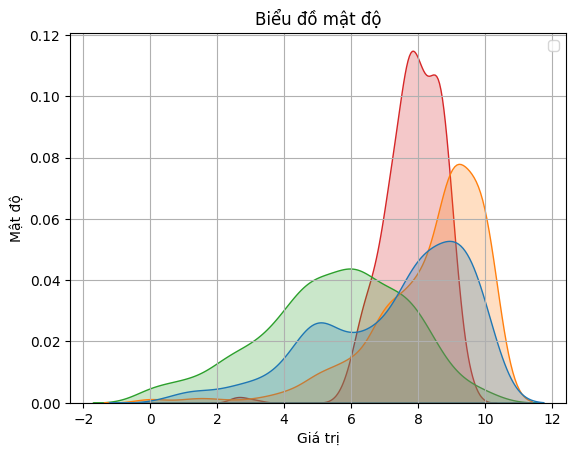

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Tạo một DataFrame mới để dễ dàng vẽ nhiều đường
df = pd.DataFrame({'TH': th_df['TH'], 'QT': qt_df['QT'], 'CK': ck_df['CK'], 'TBTL': tbtl_df['TBTL']})

# Vẽ biểu đồ KDE cho từng cột (tức từng tập dữ liệu)
sns.kdeplot(data=df, shade=True)

# Tùy chỉnh biểu đồ
plt.xlabel('Giá trị')
plt.ylabel('Mật độ')
plt.title('Biểu đồ mật độ')
plt.grid(True)
plt.legend()  # Hiển thị legend để phân biệt các đường

plt.show()

In [ ]:
# Tạo dataFrame cho các đặc trưng mới
df_final = df.copy()

In [ ]:
# Bài nộp final được điểm tối đa
full_score = df[(df['is_final'] == 1) & (df['pre_score'] == 10000)]

# Số bài nộp ứng với mỗi user
total_final_submit = full_score.groupby('username').size().reset_index(name='total_final_submit')

df_final = pd.merge(df_final, total_final_submit, on='username', how='left')

df_final['total_final_submit'] = df_final['total_final_submit'].fillna(0).astype(int)

In [ ]:
# Số bài đã nộp
submission_counts = df_final.groupby('username').size()
df_final['n_submit'] = df_final['username'].map(submission_counts)

# Số assignment đã nộp
asm_submit = df_final.groupby('username')['assignment_id'].nunique()
df_final['n_asgm_submit'] = df_final['username'].map(asm_submit)

# Số problem đã nộp
pro_submit = df_final.groupby('username')['problem_id'].nunique()
df_final['n_prob_submit'] = df_final['username'].map(pro_submit)

In [ ]:
df_final = df_final[(df_final['is_final'] == 1) & (df_final['pre_score'] == 10000)]
df_final = df_final.drop_duplicates(subset=['username', 'problem_id'], keep='first')

# Tính điểm cho mỗi problem_id
df_final['score'] = (df_final['pre_score']/100) * (df_final['coefficient']/100)

# Tính tổng điểm cho mỗi username
total_scores = df_final.groupby('username')['score'].sum().reset_index(name='total_score')

df_final = df_final.merge(total_scores, on='username', how='left')

df_final['total_score'] = df_final['total_score'].fillna(0)

In [ ]:
# Số status là 'SCORE' mỗi username
is_score = df[(df['status'] == 'SCORE')]

total_is_score = full_score.groupby('username').size().reset_index(name='total_is_score')
df_final = pd.merge(df_final, total_is_score, on='username', how='left')

df_final['total_is_score'] = df_final['total_is_score'].fillna(0).astype(int)

In [ ]:
# Tỉ lệ bài nộp final điểm tối đa
df_final['total_final_submit_rate'] = df_final['total_final_submit'] / df_final['n_submit'] * 100

# Tỉ lệ bài nộp không có điểm
df_final['score_rate'] = (1 - df_final['total_is_score'] / df_final['n_submit']) * 100

In [ ]:
#Xác định các assignment_id cho mỗi problem_id
assignments_per_problem = df_final.groupby('problem_id')['assignment_id'].unique()

#Tính số lượng sinh viên đã tham gia mỗi assignment_id
students_per_assignment = df_final.groupby('assignment_id')['username'].nunique()

#Xác định số sinh viên đã tham gia mỗi problem_id thông qua các assignment_id
students_per_problem = assignments_per_problem.apply(lambda x: students_per_assignment.loc[x].sum())

#Tính số sinh viên đã giải được mỗi problem_id
final_solutions = df_final[(df_final['is_final'] == 1) & (df_final['pre_score'] == 10000)]
solved_counts = final_solutions.groupby('problem_id')['username'].nunique()

#Tính tỷ lệ giữa số sinh viên đã giải được và số sinh viên đã tham gia
problem_solved_rate = (solved_counts / students_per_problem * 100).fillna(0)

#Tạo DataFrame mới với thông tin
lv_df = pd.DataFrame({
    'problem_id': students_per_problem.index,
    'participated': students_per_problem.values,
    'solved': solved_counts.reindex(students_per_problem.index, fill_value=0).values,
    'problem_solved_rate': problem_solved_rate.values
})

In [ ]:
def classify_level(ratio):
    if ratio >= 60:
        return 'level_1'
    elif 35 <= ratio < 60:
        return 'level_2'
    elif 20 <= ratio < 35:
        return 'level_3'
    elif 10 <= ratio < 20:
        return 'level_4'
    else:
        return 'level_5'

# Tạo cột mới 'level' dựa trên các giá trị của cột 'problem_solved_rate'
lv_df['level'] = lv_df['problem_solved_rate'].apply(classify_level)

In [ ]:
# Ghép cột level vào df gốc
df_final = pd.merge(df_final, lv_df[['problem_id', 'level']], on='problem_id', how='left')

# Lọc các bài final
ac_submissions = df_final[(df_final['is_final'] == 1) & (df_final['pre_score'] == 10000)]

# Nhóm theo username và level, đếm số lượng
level_counts = ac_submissions.groupby(['username', 'level']).size().unstack(fill_value=0).reset_index()

# Gộp vào df gốc
df_final = pd.merge(df_final, level_counts, on='username', how='left')

# Điền 0 vào các vị trí NaN
level_columns = ['level_1', 'level_2', 'level_3', 'level_4', 'level_5']
for column in level_columns:
    df_final[column] = df_final[column].fillna(0).astype(int)

# Hiển thị kết quả
df_final.drop(columns='level', inplace=True)
display(df_final)

,assignment_id,problem_id,username,is_final,status,pre_score,coefficient,language_id,created_at,updated_at,...,score,total_score,total_is_score,total_final_submit_rate,score_rate,level_1,level_2,level_3,level_4,level_5
0,90ce27571176d87961b565d5ef4b3de33ede04ac,789454427dd4097a14749e3dde63346b7a8d3811,ed9eaeb6a707f50154024b24d7efcb874a9795dd,1,SCORE,10000,100,it0012,10-09 08:06:49,10-09 08:06:58,...,100.0,5600.0,56,40.287770,59.712230,55,1,0,0,0
1,90ce27571176d87961b565d5ef4b3de33ede04ac,bf96fbdc5f499538c3e2bfbec5779c8a14b0a9ff,ed9eaeb6a707f50154024b24d7efcb874a9795dd,1,SCORE,10000,100,it0012,10-09 08:47:52,10-09 08:48:01,...,100.0,5600.0,56,40.287770,59.712230,55,1,0,0,0
2,90ce27571176d87961b565d5ef4b3de33ede04ac,7a6e5ca470ff47c3b5048f240c4738de71010c78,ed9eaeb6a707f50154024b24d7efcb874a9795dd,1,SCORE,10000,100,it0012,10-09 09:19:35,10-09 09:19:45,...,100.0,5600.0,56,40.287770,59.712230,55,1,0,0,0
3,90ce27571176d87961b565d5ef4b3de33ede04ac,d6a5bdd7f7f32364f4743854ef3b5369c0706677,ed9eaeb6a707f50154024b24d7efcb874a9795dd,1,SCORE,10000,100,it0012,10-09 09:29:58,10-09 09:30:08,...,100.0,5600.0,56,40.287770,59.712230,55,1,0,0,0
4,90ce27571176d87961b565d5ef4b3de33ede04ac,8b15ab090e1e8ec3284cf78746d94ffa00bd201b,ed9eaeb6a707f50154024b24d7efcb874a9795dd,1,SCORE,10000,100,it0012,10-09 09:42:44,10-09 09:42:54,...,100.0,5600.0,56,40.287770,59.712230,55,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85964,613aea04c978f5e72fffc8bcff1f7b695a63f7b1,60a1fdf13294f3284ea3bb1f51ae20d8b306a010,232cce96362898f08e9150ba244adaf2d6583ab2,1,SCORE,10000,100,it0012,01-15 16:03:16,01-15 16:03:23,...,100.0,9600.0,96,42.105263,57.894737,94,2,0,0,0
85965,613aea04c978f5e72fffc8bcff1f7b695a63f7b1,388516cbf597351226be1bdbe5ef30b9dcef570f,232cce96362898f08e9150ba244adaf2d6583ab2,1,SCORE,10000,100,it0012,01-15 16:03:43,01-15 16:03:53,...,100.0,9600.0,96,42.105263,57.894737,94,2,0,0,0
85966,613aea04c978f5e72fffc8bcff1f7b695a63f7b1,d2b96124ccb8e27b4b8dacdb935e729cb1ba546b,232cce96362898f08e9150ba244adaf2d6583ab2,1,SCORE,10000,100,it0012,01-15 16:04:58,01-15 16:05:08,...,100.0,9600.0,96,42.105263,57.894737,94,2,0,0,0
85967,613aea04c978f5e72fffc8bcff1f7b695a63f7b1,8c0f8dd4ff55e1609f733e043ac5e88b1dde6e7c,232cce96362898f08e9150ba244adaf2d6583ab2,1,SCORE,10000,100,it0012,01-15 16:05:13,01-15 16:05:22,...,100.0,9600.0,96,42.105263,57.894737,94,2,0,0,0


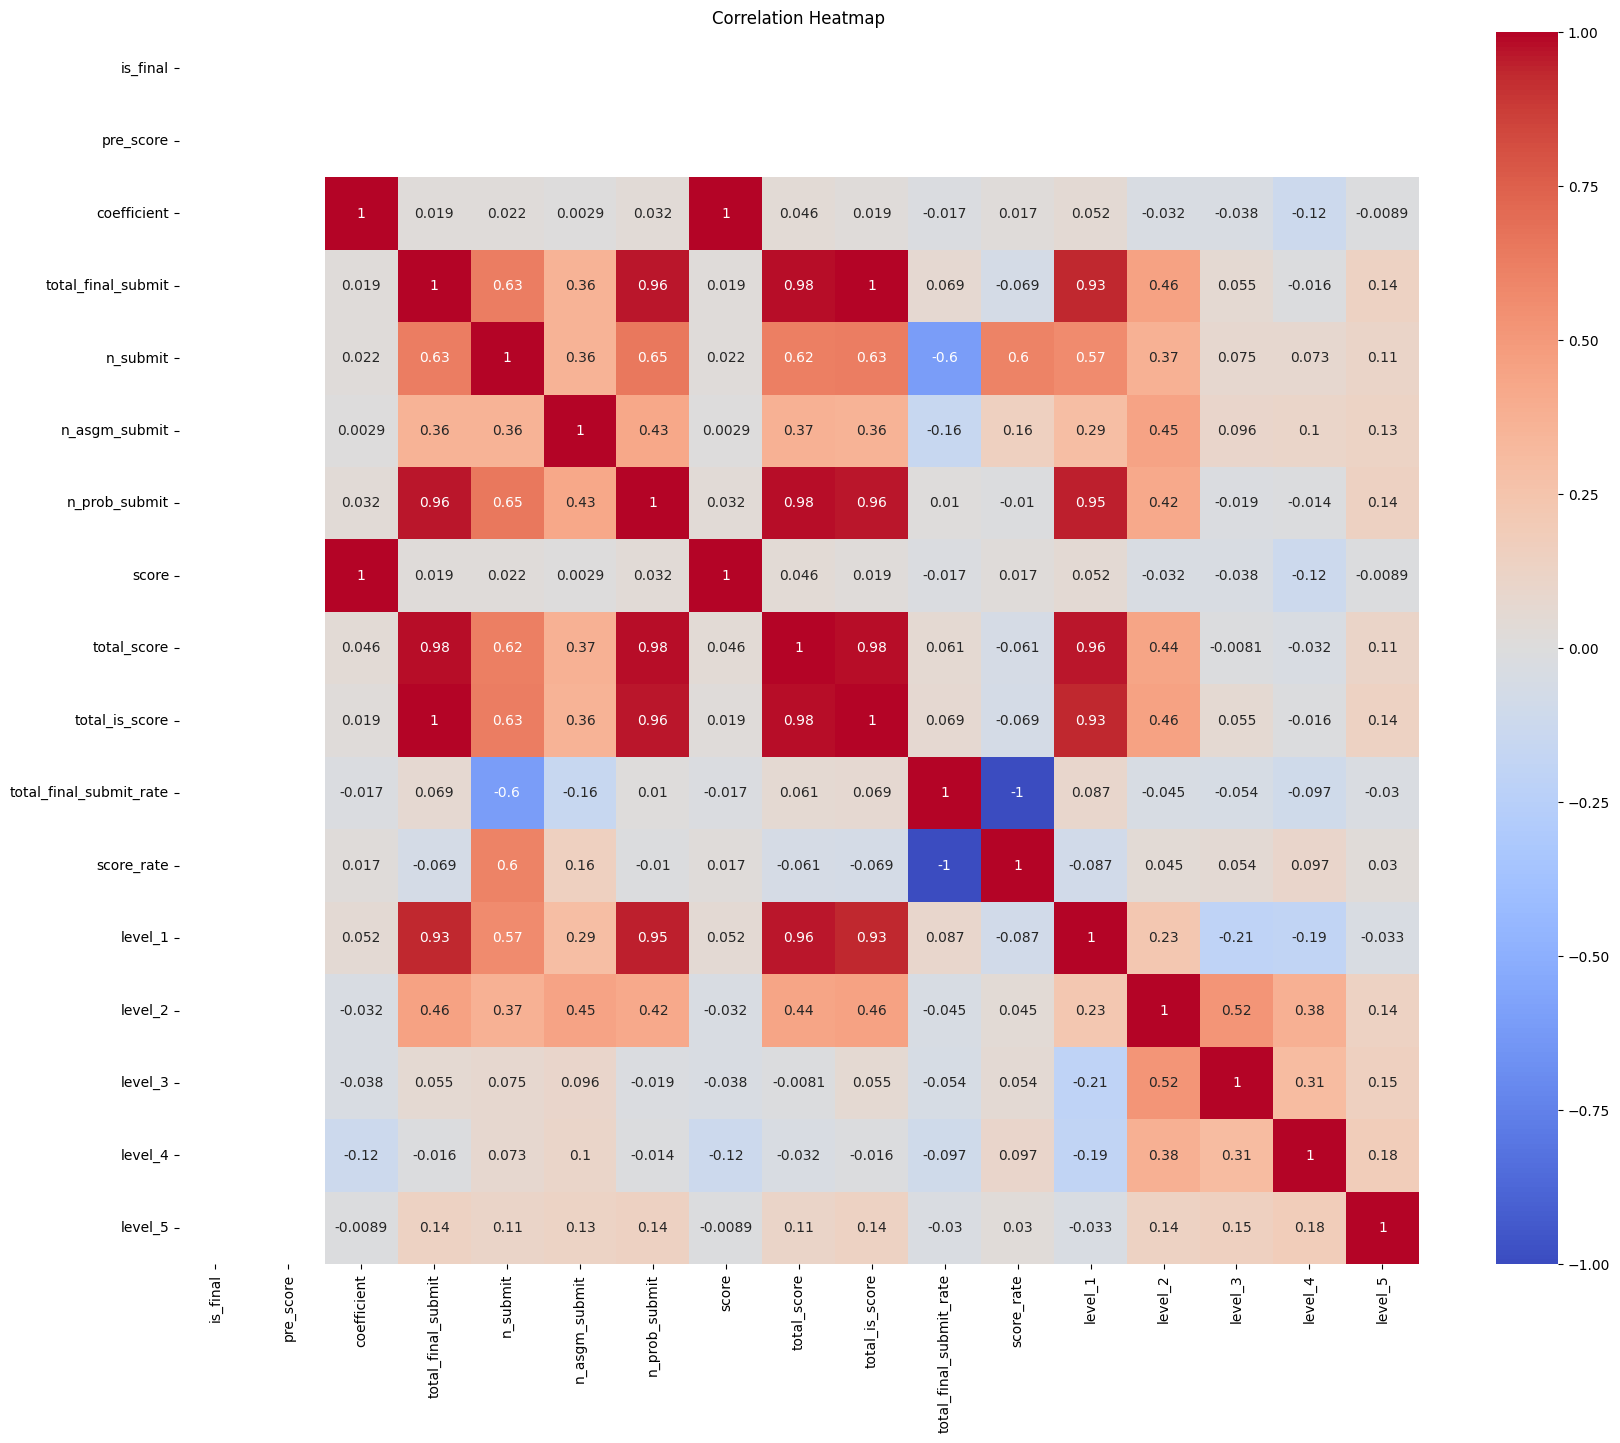

In [ ]:
# Tạo bản sao của df_statistics để phân tích
full_df_temp = df_final.copy()

# Tính ma trận tương quan
full_df_temp_corr = full_df_temp.drop(columns=['username', 'assignment_id', 'problem_id', 'status', 'language_id', 'created_at', 'updated_at', 'judgement'])
corr_matrix = full_df_temp_corr.corr()

# Vẽ biểu đồ heatmap tương quan
plt.figure(figsize=(20, 16))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()

In [ ]:
def create_train_predict_df(df, df_final):
    train_df = df.copy()
    sv_id = train_df['username']
    sv_id_anno = df_final['username']

    # Tìm các giá trị "sv_id" có trong annonimized_df nhưng không có trong df_predict - cần predict
    unique_sv_ids = sv_id_anno[~sv_id_anno.isin(sv_id)]

    # Lọc các hàng trong annonimized_df mà có "sv_id" nằm trong unique_sv_ids
    fil_df = df_final[df_final['username'].isin(unique_sv_ids)]
    unique_values = fil_df['username'].unique()

    predict_df = pd.DataFrame(unique_values, columns=['username'])
    predict_col = df.columns[1]
    ac_summary = df_final.groupby('username').first().reset_index()
    train_df = pd.merge(train_df, ac_summary, on='username', how='left')
    predict_df = pd.merge(predict_df, ac_summary, on='username', how='left')
    original_col = ['assignment_id', 'problem_id', 'is_final', 'status', 'pre_score', 'coefficient', 'language_id', 'created_at', 'updated_at', 'judgement']
    train_df.drop(columns=original_col, inplace=True)
    predict_df.drop(columns=original_col, inplace=True)
    train_df.dropna(subset=predict_col, inplace=True)
    train_df.dropna(inplace=True)
    return train_df, predict_df

train_df_TH, predict_df_TH = create_train_predict_df(th_df, df_final)
train_df_QT, predict_df_QT = create_train_predict_df(qt_df, df_final)
train_df_CK, predict_df_CK = create_train_predict_df(ck_df, df_final)
train_df_TL, predict_df_TL = create_train_predict_df(tbtl_df, df_final)

# Model

---



# QT

In [ ]:
# Train
X_QT = train_df_QT.drop(columns=[train_df_QT.columns[1], 'username'])
y_QT = train_df_QT[train_df_QT.columns[1]]
X_train, X_test, y_train, y_test = train_test_split(X_QT, y_QT, test_size=0.3, random_state=42)
model = GradientBoostingRegressor()
model.fit(X_QT, y_QT)

y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print("R-squared:", r2)

R-squared: 0.5286532952383607


In [ ]:
X_QT

,total_final_submit,n_submit,n_asgm_submit,n_prob_submit,score,total_score,total_is_score,total_final_submit_rate,score_rate,level_1,level_2,level_3,level_4,level_5
0,46.0,147.0,7.0,46.0,100.0,4500.0,46.0,31.292517,68.707483,36.0,6.0,3.0,0.0,0.0
1,72.0,259.0,9.0,78.0,100.0,7200.0,72.0,27.799228,72.200772,66.0,6.0,0.0,0.0,0.0
2,59.0,195.0,7.0,66.0,100.0,5800.0,59.0,30.256410,69.743590,39.0,4.0,5.0,2.0,8.0
3,58.0,107.0,8.0,52.0,100.0,4400.0,58.0,54.205607,45.794393,41.0,2.0,0.0,1.0,0.0
4,79.0,199.0,9.0,90.0,100.0,7900.0,79.0,39.698492,60.301508,72.0,7.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
749,39.0,111.0,6.0,43.0,100.0,3700.0,39.0,35.135135,64.864865,33.0,3.0,1.0,0.0,0.0
750,102.0,357.0,17.0,104.0,100.0,10200.0,102.0,28.571429,71.428571,91.0,11.0,0.0,0.0,0.0
751,47.0,155.0,8.0,52.0,100.0,4700.0,47.0,30.322581,69.677419,46.0,1.0,0.0,0.0,0.0
752,109.0,557.0,12.0,114.0,100.0,10900.0,109.0,19.569120,80.430880,90.0,10.0,2.0,5.0,2.0


In [ ]:
# Predict
predicted_target = model.predict(predict_df_QT.drop(columns=['username']))
predict_df_QT['target'] = predicted_target
predict_df_QT['target'] = predict_df_QT['target'].apply(lambda x: min(max(x, 0), 10))
result = predict_df_QT[['username', 'target']]

In [ ]:
result.to_csv('predict_qt.csv', index=False, header=False)

# TH

In [ ]:
# Train
X_TH = train_df_TH.drop(columns=[train_df_TH.columns[1], 'username'])
y_TH = train_df_TH[train_df_TH.columns[1]]
X_train, X_test, y_train, y_test = train_test_split(X_TH, y_TH, test_size=0.3, random_state=42)
model = GradientBoostingRegressor()
model.fit(X_TH, y_TH)

y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print("R-squared:", r2)

R-squared: 0.6618379638294756


In [ ]:
# Predict
predicted_target = model.predict(predict_df_TH.drop(columns=['username']))
predict_df_TH['target'] = predicted_target
predict_df_TH['target'] = predict_df_TH['target'].apply(lambda x: min(max(x, 0), 10))
result = predict_df_TH[['username', 'target']]

In [ ]:
result.to_csv('predict_th.csv', index=False, header=False)

# CK

In [ ]:
# Train
X_CK = train_df_CK.drop(columns=[train_df_CK.columns[1], 'username'])
y_CK = train_df_CK[train_df_CK.columns[1]]
X_train, X_test, y_train, y_test = train_test_split(X_CK, y_CK, test_size=0.3, random_state=42)
model = GradientBoostingRegressor()
model.fit(X_CK, y_CK)

y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print("R-squared:", r2)

R-squared: 0.6062111145177134


In [ ]:
# Predict
predicted_target = model.predict(predict_df_CK.drop(columns=['username']))
predict_df_CK['target'] = predicted_target
predict_df_CK['target'] = predict_df_CK['target'].apply(lambda x: min(max(x, 0), 10))
result = predict_df_CK[['username', 'target']]

In [ ]:
result.to_csv('predict_ck.csv', index=False, header=False)

# TBTL

In [ ]:
# Train
X_TL = train_df_TL.drop(columns=[train_df_TL.columns[1], 'username'])
y_TL = train_df_TL[train_df_TL.columns[1]]
X_train, X_test, y_train, y_test = train_test_split(X_TL, y_TL, test_size=0.3, random_state=42)
model = GradientBoostingRegressor()
model.fit(X_TL, y_TL)

y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print("R-squared:", r2)

R-squared: 0.5373345400497751


In [ ]:
# Predict
predicted_target = model.predict(predict_df_TL.drop(columns=['username']))
predict_df_TL['target'] = predicted_target
predict_df_TL['target'] = predict_df_TL['target'].apply(lambda x: min(max(x, 0), 10))
result = predict_df_TL[['username', 'target']]

In [ ]:
result.to_csv('predict_tbtl.csv', index=False, header=False)